### import packages and configure

In [1]:
import os
import sys

In [2]:
import numpy as np
import pandas as pd

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!pwd

/Users/lcx/Documents/courses/udacity_DS/2-Intro_to_DS/project_medium_post/notebooks


In [5]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import seaborn as sns

In [6]:
sys.path.insert(1, '/Users/lcx/Documents/courses/udacity_DS/2-Intro_to_DS/project_medium_post/code')

In [7]:
from data_process import extract_data_related

In [8]:
root_dir = '/Users/lcx/Documents/courses/udacity_DS/2-Intro_to_DS/project_medium_post'

In [9]:
!pwd

/Users/lcx/Documents/courses/udacity_DS/2-Intro_to_DS/project_medium_post/notebooks


In [10]:
df_survey = pd.read_csv(os.path.join(root_dir, 'data/developer_survey_2020/survey_results_public.csv'))

In [11]:
df_survey.shape

(64461, 61)

In [12]:
# how many missing DevType

df_survey['DevType'].isnull().sum()

15091

Questions:

1. Among the data-related roles (data scientist, data analyst, data engineer), what makes the most?
2. What are the trends of data-related role in last three year?
    * Payment;
    * numbers of data roles;
    * Job satisfaction.
3. How to predict job satisfaction for data-related roles?

## 1. Exploratory analysis of data-related developers

In [13]:
from collections import defaultdict

In [14]:
# get the counts of different developer types

df_DevType = df_survey['DevType'].value_counts().to_frame().reset_index().rename(columns={'DevType':'count', 'index': 'DevType'})

In [15]:
# replace ',' by '_' so we can split the string of DevType into a list later

df_DevType['DevType_list'] = df_DevType['DevType'].str.replace(', ', '_').str.split(';')

df_DevType['DevType_list'] = df_DevType['DevType_list'].apply(lambda x: set(x))  # convert list to dictionary for efficiency

df_DevType

,DevType,count,DevType_list
0,"Developer, full-stack",4424,{Developer_full-stack}
1,"Developer, back-end",3086,{Developer_back-end}
2,"Developer, back-end;Developer, front-end;Devel...",2227,"{Developer_back-end, Developer_full-stack, Dev..."
3,"Developer, back-end;Developer, full-stack",1476,"{Developer_back-end, Developer_full-stack}"
4,"Developer, front-end",1401,{Developer_front-end}
...,...,...,...
8264,Data or business analyst;Data scientist or mac...,1,"{Engineer_data, Developer_desktop or enterpris..."
8265,"Designer;Developer, back-end;Developer, front-...",1,"{Developer_front-end, Educator, Designer, Prod..."
8266,"Developer, desktop or enterprise applications;...",1,"{System administrator, Developer_desktop or en..."
8267,"Developer, back-end;Developer, desktop or ente...",1,"{Developer_front-end, Developer_mobile, Develo..."


### 1.1. filter rows to focus on data-related roles:
* Data scientist or machine learning specialist
* Data or business analyst
* Engineer, data
    

In [16]:
df_DevType['data_related'] = df_DevType['DevType'].\
    str.contains('data(?![a-z])', case=False, regex=True)

df_DevType_data = df_DevType[df_DevType['data_related']==True].copy()

df_DevType_data.shape

(3889, 4)

In [17]:
df_DevType_data.head(5)

,DevType,count,DevType_list,data_related
13,Data scientist or machine learning specialist,369,{Data scientist or machine learning specialist},True
17,Data or business analyst,285,{Data or business analyst},True
24,"Developer, back-end;Engineer, data",227,"{Developer_back-end, Engineer_data}",True
30,"Engineer, data",189,{Engineer_data},True
32,Data or business analyst;Data scientist or mac...,186,"{Data or business analyst, Data scientist or m...",True


In [18]:
print(f"Percentage of data-related roles from survey: {sum(df_DevType_data['count']) / len(df_survey)*100: 5.2f}%")

Percentage of data-related roles from survey:  13.54%


In [19]:
sum(df_DevType_data['count'])

8726

### 1.2. count number of different roles (associated with data-related)

In [20]:
data_role_count = defaultdict(int)

for idx, row in df_DevType_data.iterrows():
    for role in row['DevType_list']:
        data_role_count[role] = data_role_count[role] + row['count']

In [22]:
data_role_count

defaultdict(int,
            {'Data scientist or machine learning specialist': 3988,
             'Data or business analyst': 4024,
             'Developer_back-end': 4843,
             'Engineer_data': 3738,
             'Academic researcher': 1585,
             'Scientist': 1140,
             'Developer_full-stack': 3814,
             'Developer_mobile': 1339,
             'Developer_desktop or enterprise applications': 2184,
             'Engineer_site reliability': 631,
             'Engineering manager': 771,
             'Developer_embedded applications or devices': 1024,
             'Marketing or sales professional': 295,
             'System administrator': 1504,
             'DevOps specialist': 1359,
             'Developer_front-end': 2578,
             'Database administrator': 2220,
             'Educator': 891,
             'Developer_QA or test': 987,
             'Designer': 1344,
             'Product manager': 876,
             'Developer_game or graphics': 563,
    

Text(0.5, 1.0, 'data-related roles count')

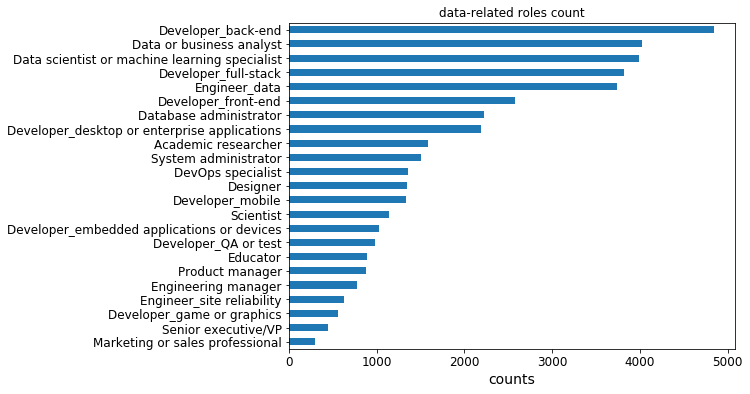

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.Series(data_role_count).sort_values().plot.barh(ax=ax)

ax.set_xlabel('counts')
ax.set_title('data-related roles count')

Text(0.5, 1.0, 'data roles (DS, DA, DE) count')

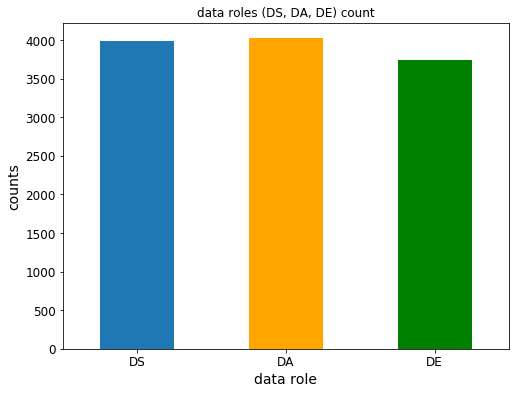

In [70]:
fig, ax = plt.subplots(figsize=(8, 6))

data_role_count_1 = {'DS': 3988, 'DA': 4024, 'DE': 3738}

pd.Series(data_role_count_1).plot(kind='bar', color=['C0', 'orange', 'green'], ax=ax, rot=0)

ax.set_xlabel('data role') 
# ax.set_xticklabels(ax.get_xticks(), rotation=90)
ax.set_ylabel('counts')
ax.set_title('data roles (DS, DA, DE) count')

### 1.3. count roles associated with each data role (Data Scientist, Data Analysis, Data Engineer)

In [27]:
DS_multiple_roles = defaultdict(int)
DA_multiple_roles = defaultdict(int)
DE_multiple_roles = defaultdict(int)

DS_counts, DA_counts, DE_counts = 0, 0, 0
DS_only_counts, DA_only_counts, DE_only_counts = 0, 0, 0

for idx, row in df_DevType_data.iterrows(): 
            
    if 'Data scientist or machine learning specialist' in row['DevType_list']:
        DS_counts += row['count']
        if len(row['DevType_list']) == 1:
            DS_only_counts += row['count']
        for role in row['DevType_list']:
            DS_multiple_roles[role] = DS_multiple_roles[role] + row['count']
    
    if 'Data or business analyst' in row['DevType_list']:
        DA_counts += row['count']
        if len(row['DevType_list']) == 1:
            DA_only_counts += row['count']
        for role in row['DevType_list']:
            DA_multiple_roles[role] = DA_multiple_roles[role] + row['count']
            
    if 'Engineer_data' in row['DevType_list']:
        DE_counts += row['count']
        if len(row['DevType_list']) == 1:
            DE_only_counts += row['count']
        for role in row['DevType_list']:
            DE_multiple_roles[role] = DE_multiple_roles[role] + row['count']



In [28]:
index = ['DS', 'DA', 'DE']
total_count = [DS_counts, DA_counts, DE_counts]
only_count = [DS_only_counts, DA_only_counts, DE_only_counts]

df_counts = pd.DataFrame({'total_count': total_count, 'only_count': only_count}, index=index)

In [29]:
df_counts

,total_count,only_count
DS,3988,369
DA,4024,285
DE,3738,189


In [30]:
# how often the data role has the other developer duty
1 - df_counts['only_count'] / df_counts['total_count']

DS    0.907472
DA    0.929175
DE    0.949438
dtype: float64

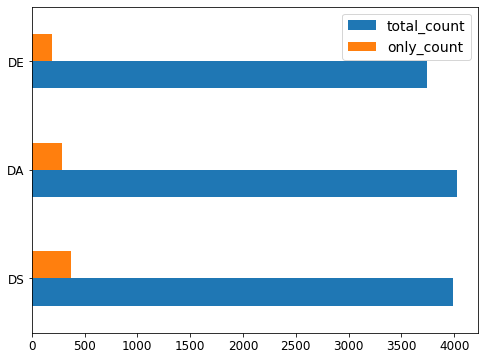

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

df_counts.plot.barh(ax=ax)

In [41]:
df_DevType_data[df_DevType_data['DevType'] == 'Data or business analyst']

,DevType,count,DevType_list,data_related
18,Data or business analyst,285,{Data or business analyst},True


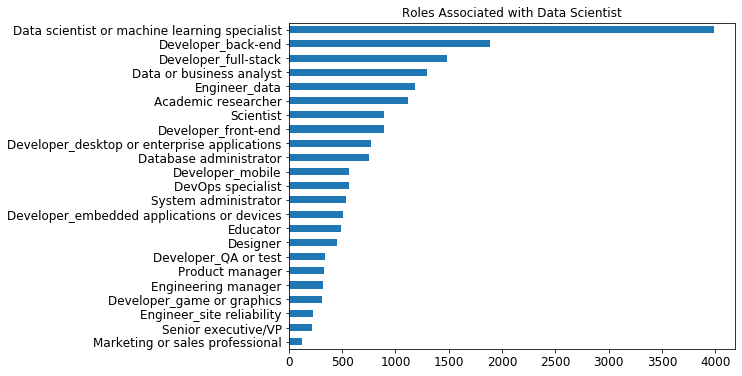

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

pd.Series(DS_multiple_roles).sort_values(ascending=True).plot.barh(ax=ax, 
                                                                   title='Roles Associated with Data Scientist')

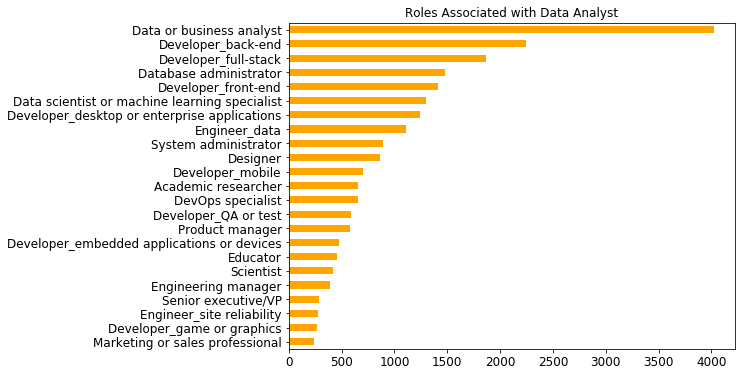

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))

pd.Series(DA_multiple_roles).sort_values(ascending=True).plot.barh(ax=ax, 
                                                                   title='Roles Associated with Data Analyst', color='orange')

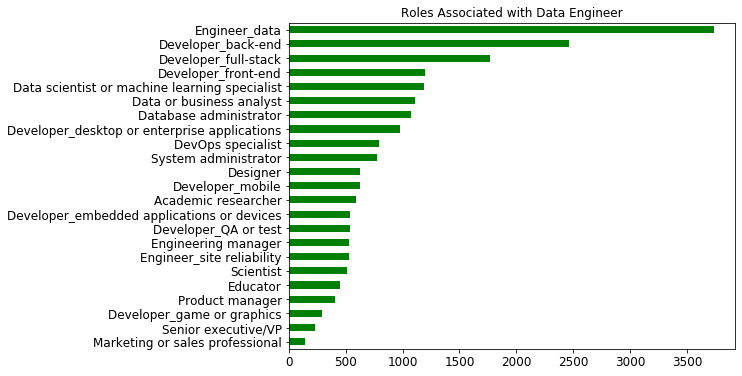

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))

pd.Series(DE_multiple_roles).sort_values(ascending=True).plot.barh(ax=ax, 
                                                                   title='Roles Associated with Data Engineer', color='green')

## 2. Question: which data role earns the most?

### 2.1. convert raw data to dataframe with data-related roles

In [71]:
df_survey['data_related'] = df_survey['DevType'].\
    str.contains('data(?![a-z])', case=False, regex=True)

df_data = df_survey[df_survey['data_related']==True].copy()

In [72]:
df_data.shape

(8726, 62)

In [73]:
df_survey.shape

(64461, 62)

In [74]:
df_data['DevType']

21                    Developer, full-stack;Engineer, data
24       Developer, back-end;Developer, full-stack;DevO...
29       Data or business analyst;Database administrato...
35       Data or business analyst;Data scientist or mac...
43       Data or business analyst;Developer, back-end;P...
                               ...                        
64432    Data scientist or machine learning specialist;...
64437                             Data or business analyst
64446    Academic researcher;Data or business analyst;D...
64451        Data scientist or machine learning specialist
64453    Data or business analyst;Developer, mobile;Sen...
Name: DevType, Length: 8726, dtype: object

**Note**:

we can see for responders who have a data professional, there could be more than one role. 

We convert one row to multiple rows if he/she has the roles as 'Data Scientist'/'Data Engineer'/'Data Analyst'.

In [75]:
df_data = extract_data_related(df_survey)

In [76]:
df_data.shape

(11750, 65)

In [77]:
df_data.head(5)

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro,data_related,DevType_list,multiple_roles,data_role
35,36,"I am not primarily a developer, but I write co...",Yes,34.0,30,Yearly,60000.0,77556.0,United Kingdom,Pound sterling,...,Express;React.js,Express;React.js,Just as welcome now as I felt last year,40.0,4,3,True,"{Data or business analyst, Data scientist or m...",True,DS
46,47,I am a developer by profession,Yes,53.0,10,Yearly,58000.0,74970.0,United Kingdom,Pound sterling,...,Flask;Spring,Flask;Spring,Just as welcome now as I felt last year,40.0,43,28,True,"{Scientist, Engineer_data, Developer_QA or tes...",True,DS
68,69,I am a developer by profession,Yes,25.0,12,Yearly,550000.0,594539.0,France,European Euro,...,Django;Flask,Django;Flask,Just as welcome now as I felt last year,40.0,13,3,True,"{Engineer_data, Database administrator, Develo...",True,DS
71,72,I am a developer by profession,Yes,25.0,16,NaN,NaN,NaN,United States,NaN,...,NaN,NaN,Just as welcome now as I felt last year,NaN,10,NaN,True,"{Data or business analyst, Engineer_data, Data...",True,DS
76,77,"I am not primarily a developer, but I write co...",Yes,NaN,6,NaN,NaN,NaN,United States,United States dollar,...,NaN,NaN,Just as welcome now as I felt last year,60.0,30,16,True,"{Academic researcher, Data scientist or machin...",False,DS


In [41]:
df_data['JobSat'].isnull().sum()

1378

In [80]:
df_data.columns

Index(['Respondent', 'MainBranch', 'Hobbyist', 'Age', 'Age1stCode', 'CompFreq',
       'CompTotal', 'ConvertedComp', 'Country', 'CurrencyDesc',
       'CurrencySymbol', 'DatabaseDesireNextYear', 'DatabaseWorkedWith',
       'DevType', 'EdLevel', 'Employment', 'Ethnicity', 'Gender', 'JobFactors',
       'JobSat', 'JobSeek', 'LanguageDesireNextYear', 'LanguageWorkedWith',
       'MiscTechDesireNextYear', 'MiscTechWorkedWith',
       'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWDevOps',
       'NEWDevOpsImpt', 'NEWEdImpt', 'NEWJobHunt', 'NEWJobHuntResearch',
       'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms',
       'NEWOvertime', 'NEWPurchaseResearch', 'NEWPurpleLink', 'NEWSOSites',
       'NEWStuck', 'OpSys', 'OrgSize', 'PlatformDesireNextYear',
       'PlatformWorkedWith', 'PurchaseWhat', 'Sexuality', 'SOAccount',
       'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength',
       'Trans', 'UndergradMajor', 'WebframeDesireNextYear',
  

### 2.2. exploratory anaylsis and visulization

### **payment v.s. data role**

In [82]:
df_data['data_role'].value_counts()

DA    4024
DS    3988
DE    3738
Name: data_role, dtype: int64

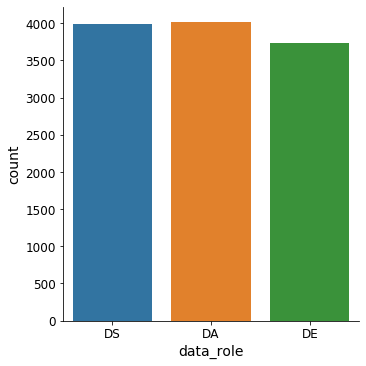

In [84]:
sns.catplot(x="data_role", kind='count', data=df_data)

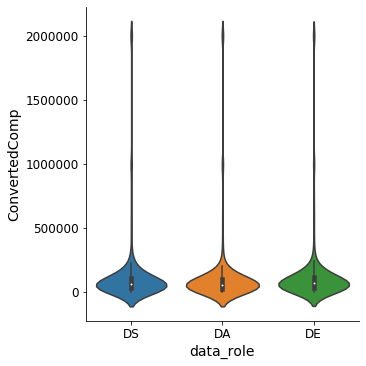

In [43]:
sns.catplot(x='data_role', y="ConvertedComp", kind="violin", data=df_data)

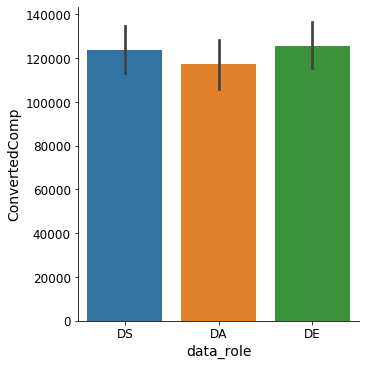

In [44]:
sns.catplot(x='data_role', y="ConvertedComp", kind='bar', data=df_data)

### **payment v.s. data role in different countries**

In [45]:
# get countries with top 9 counts
df_data['Country'].value_counts().iloc[:9]

United States     2844
India             1257
Germany            679
United Kingdom     663
Canada             364
Brazil             360
France             323
Australia          264
Netherlands        249
Name: Country, dtype: int64

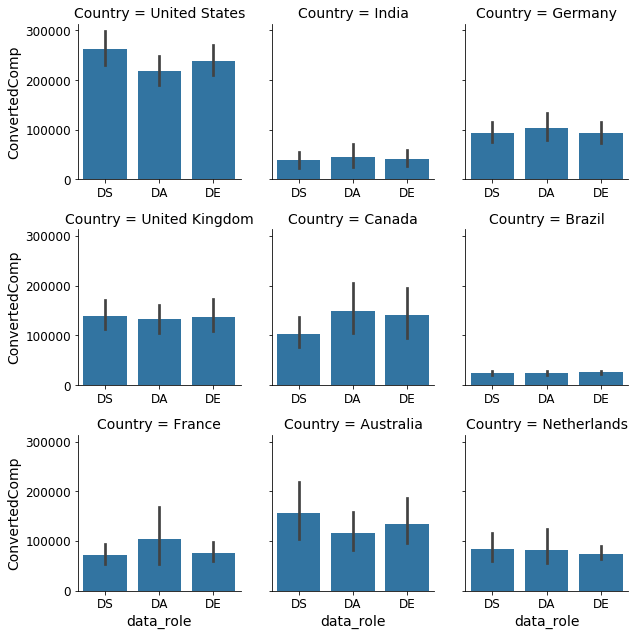

In [46]:
top_ten_countries = ['United States', 'India', 'Germany', 'United Kingdom', 'Canada', 
                     'Brazil', 'France', 'Australia', 'Netherlands']

g = sns.FacetGrid(df_data[df_data['Country'].isin(top_ten_countries)], 
                  col='Country', 
                  col_wrap=3, col_order=top_ten_countries, sharex=False)
g.map(sns.barplot, 'data_role', "ConvertedComp", order=["DS", "DA", "DE"])

### payment vs. data role for different gender

In [47]:
df_data['Gender'].value_counts()

Man                                                            9146
Woman                                                           774
Non-binary, genderqueer, or gender non-conforming                68
Man;Non-binary, genderqueer, or gender non-conforming            35
Woman;Non-binary, genderqueer, or gender non-conforming          29
Woman;Man                                                        22
Woman;Man;Non-binary, genderqueer, or gender non-conforming      20
Name: Gender, dtype: int64

In [48]:
df_data['Gender_1'] = df_data['Gender'].apply(
    lambda x: x if pd.isna(x) or x == 'Man' or x == 'Woman' else 'others')

In [49]:
df_data['Gender_1'].value_counts()

Man       9146
Woman      774
others     174
Name: Gender_1, dtype: int64

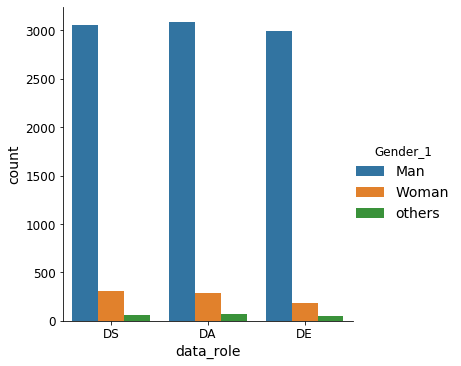

In [50]:
gender_types = ['Man', 'Woman', 'others']

sns.catplot(x='data_role', kind='count', hue='Gender_1', 
            data=df_data)

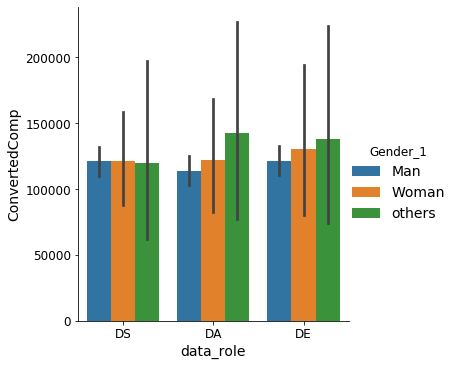

In [51]:
gender_types = ['Man', 'Woman', 'others']

sns.catplot(x='data_role', y='ConvertedComp', kind='bar', hue='Gender_1', 
            data=df_data)

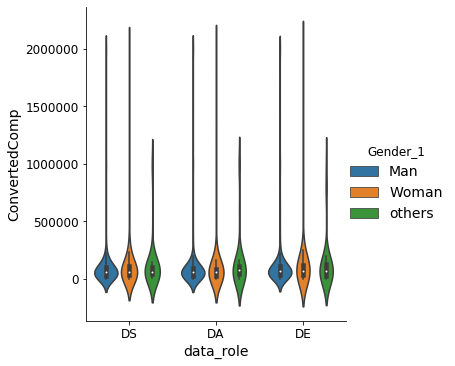

In [169]:
sns.catplot(x='data_role', y="ConvertedComp", kind="violin", hue='Gender_1', data=df_data)

### job satisfaction v.s. data role

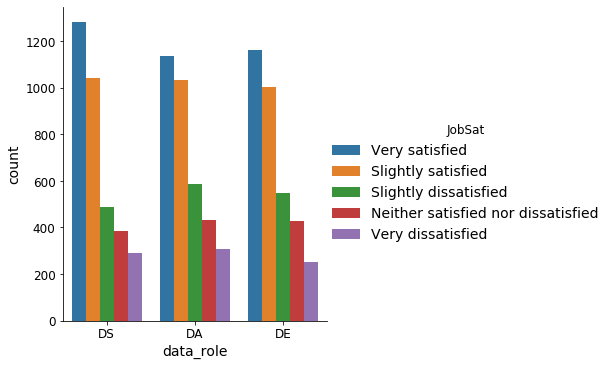

In [159]:
sns.catplot(x='data_role', kind='count', hue='JobSat', 
            data=df_data, hue_order=['Very satisfied', 'Slightly satisfied', 
                                      'Slightly dissatisfied', 
                                      'Neither satisfied nor dissatisfied', 
                                      'Very dissatisfied'])

In [ ]:
### Trend

## 4. Job Satisfation

### **job satisfaction v.s. data role**

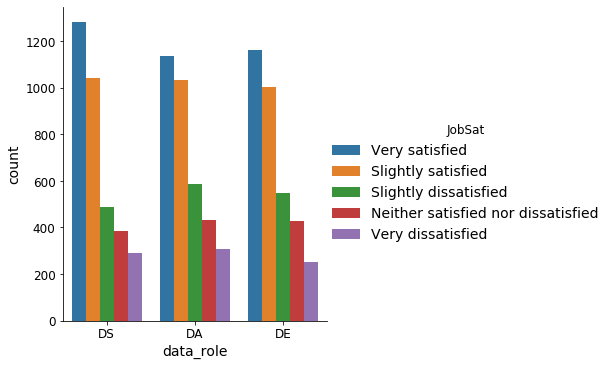

In [159]:
sns.catplot(x='data_role', kind='count', hue='JobSat', 
            data=df_data, hue_order=['Very satisfied', 'Slightly satisfied', 
                                      'Slightly dissatisfied', 
                                      'Neither satisfied nor dissatisfied', 
                                      'Very dissatisfied'])

### **Job satisfation v.s. Payment**

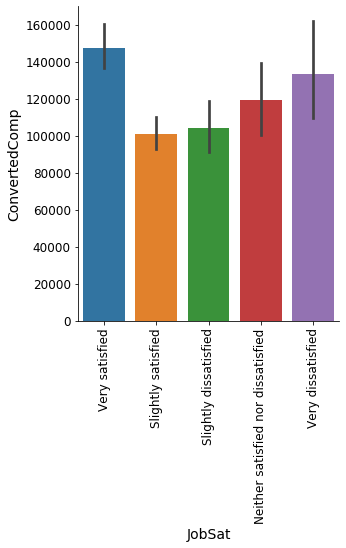

In [155]:
ax = sns.catplot(x='JobSat', y="ConvertedComp", 
                 kind='bar', 
                 data=df_data, 
                 order=['Very satisfied', 'Slightly satisfied',
                        'Slightly dissatisfied',
                        'Neither satisfied nor dissatisfied',
                        'Very dissatisfied'])

ax.set_xticklabels(rotation=90)

### job satisfaction v.s. overtime

### job satisfaction distribution in different countries

In [145]:
df_data['JobSat'].value_counts().index

Index(['Very satisfied', 'Slightly satisfied', 'Slightly dissatisfied',
       'Neither satisfied nor dissatisfied', 'Very dissatisfied'],
      dtype='object')

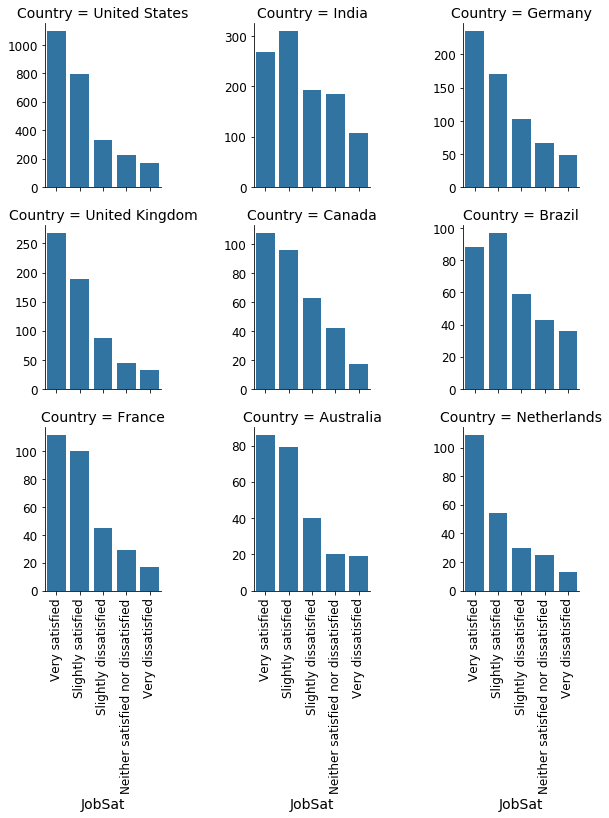

In [150]:
top_ten_countries = ['United States', 'India', 'Germany', 'United Kingdom', 'Canada', 
                     'Brazil', 'France', 'Australia', 'Netherlands']

g = sns.FacetGrid(df_data[df_data['Country'].isin(top_ten_countries)], 
                  col='Country', 
                  col_wrap=3, col_order=top_ten_countries, sharex=True, sharey=False)
g.map(sns.countplot, 'JobSat', order=['Very satisfied', 'Slightly satisfied', 
                                      'Slightly dissatisfied', 
                                      'Neither satisfied nor dissatisfied', 
                                      'Very dissatisfied'])

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

## 3. Modelling

In [176]:
from data_process import cal_basic_info

In [171]:
df_data.shape

(11750, 66)

In [175]:
df_data.columns.tolist()

['Respondent',
 'MainBranch',
 'Hobbyist',
 'Age',
 'Age1stCode',
 'CompFreq',
 'CompTotal',
 'ConvertedComp',
 'Country',
 'CurrencyDesc',
 'CurrencySymbol',
 'DatabaseDesireNextYear',
 'DatabaseWorkedWith',
 'DevType',
 'EdLevel',
 'Employment',
 'Ethnicity',
 'Gender',
 'JobFactors',
 'JobSat',
 'JobSeek',
 'LanguageDesireNextYear',
 'LanguageWorkedWith',
 'MiscTechDesireNextYear',
 'MiscTechWorkedWith',
 'NEWCollabToolsDesireNextYear',
 'NEWCollabToolsWorkedWith',
 'NEWDevOps',
 'NEWDevOpsImpt',
 'NEWEdImpt',
 'NEWJobHunt',
 'NEWJobHuntResearch',
 'NEWLearn',
 'NEWOffTopic',
 'NEWOnboardGood',
 'NEWOtherComms',
 'NEWOvertime',
 'NEWPurchaseResearch',
 'NEWPurpleLink',
 'NEWSOSites',
 'NEWStuck',
 'OpSys',
 'OrgSize',
 'PlatformDesireNextYear',
 'PlatformWorkedWith',
 'PurchaseWhat',
 'Sexuality',
 'SOAccount',
 'SOComm',
 'SOPartFreq',
 'SOVisitFreq',
 'SurveyEase',
 'SurveyLength',
 'Trans',
 'UndergradMajor',
 'WebframeDesireNextYear',
 'WebframeWorkedWith',
 'WelcomeChange',
 'W

In [106]:
df_data.select_dtypes(include='number').columns

Index(['Respondent', 'Age', 'CompTotal', 'ConvertedComp', 'WorkWeekHrs'], dtype='object')

Note:

* only for currently employed responders


In [190]:
from sklearn.preprocessing import MultiLabelBinarizer

In [221]:
from data_process import StringtoListTranformer, ListColumnsEncoder

In [236]:
df_tmp = df_data[['LanguageWorkedWith', 'Ethnicity']]

df_tmp

,LanguageWorkedWith,Ethnicity
35,C#;Go;HTML/CSS;Java;JavaScript;Python;R;SQL,White or of European descent
46,Bash/Shell/PowerShell;C#;Java;JavaScript;Pytho...,White or of European descent
68,HTML/CSS;Python,White or of European descent
71,Bash/Shell/PowerShell;JavaScript;Python;Swift,White or of European descent
76,C++;HTML/CSS;Java;Python;R,White or of European descent
...,...,...
64344,Assembly;Bash/Shell/PowerShell;C;C#;C++;Dart;G...,NaN
64361,HTML/CSS;JavaScript,NaN
64368,Bash/Shell/PowerShell;JavaScript;Python;SQL;VBA,Hispanic or Latino/a/x;White or of European de...
64392,Assembly;Bash/Shell/PowerShell;C;C#;C++;Dart;G...,Black or of African descent;East Asian;Hispani...


In [237]:
s_to_list = StringtoListTranformer(variables=['LanguageWorkedWith', 'Ethnicity'])

In [238]:
df_tmp = s_to_list.fit_transform(df_tmp)

In [239]:
df_tmp

,LanguageWorkedWith,Ethnicity
35,"{HTML/CSS, SQL, Go, Java, JavaScript, C#, Pyth...",{White or of European descent}
46,"{SQL, Java, Ruby, Bash/Shell/PowerShell, JavaS...",{White or of European descent}
68,"{Python, HTML/CSS}",{White or of European descent}
71,"{Python, JavaScript, Swift, Bash/Shell/PowerSh...",{White or of European descent}
76,"{C++, HTML/CSS, Java, Python, R}",{White or of European descent}
...,...,...
64344,"{TypeScript, C++, HTML/CSS, Julia, JavaScript,...",{}
64361,"{JavaScript, HTML/CSS}",{}
64368,"{SQL, Bash/Shell/PowerShell, JavaScript, VBA, ...","{Hispanic or Latino/a/x, White or of European ..."
64392,"{TypeScript, C++, HTML/CSS, Julia, JavaScript,...","{Biracial, Hispanic or Latino/a/x, Middle East..."


In [240]:
list_to_cols = ListColumnsEncoder(variables=['Ethnicity'])

In [241]:
list_to_cols.fit(df_tmp)

ListColumnsEncoder(variables=['Ethnicity'])

In [242]:
list_to_cols.transform(df_tmp)

,LanguageWorkedWith,Biracial,Black or of African descent,East Asian,Hispanic or Latino/a/x,"Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)",Middle Eastern,Multiracial,South Asian,Southeast Asian,White or of European descent
35,"{HTML/CSS, SQL, Go, Java, JavaScript, C#, Pyth...",0,0,0,0,0,0,0,0,0,1
46,"{SQL, Java, Ruby, Bash/Shell/PowerShell, JavaS...",0,0,0,0,0,0,0,0,0,1
68,"{Python, HTML/CSS}",0,0,0,0,0,0,0,0,0,1
71,"{Python, JavaScript, Swift, Bash/Shell/PowerSh...",0,0,0,0,0,0,0,0,0,1
76,"{C++, HTML/CSS, Java, Python, R}",0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
64344,"{TypeScript, C++, HTML/CSS, Julia, JavaScript,...",0,0,0,0,0,0,0,0,0,0
64361,"{JavaScript, HTML/CSS}",0,0,0,0,0,0,0,0,0,0
64368,"{SQL, Bash/Shell/PowerShell, JavaScript, VBA, ...",0,0,0,1,0,0,0,0,0,1
64392,"{TypeScript, C++, HTML/CSS, Julia, JavaScript,...",1,1,1,1,1,1,1,1,1,1


In [199]:
df_data['LanguageWorkedWith'].isnull().sum()

722

In [206]:
s_language = df_data['LanguageWorkedWith'].str.split(';').apply(lambda x: {} if x is np.nan else set(x))

In [207]:
mlb = MultiLabelBinarizer()

s_language_encoded = mlb.fit_transform(s_language)

In [208]:
s_language_encoded.shape

(11750, 25)

In [209]:
mlb.classes_

array(['Assembly', 'Bash/Shell/PowerShell', 'C', 'C#', 'C++', 'Dart',
       'Go', 'HTML/CSS', 'Haskell', 'Java', 'JavaScript', 'Julia',
       'Kotlin', 'Objective-C', 'PHP', 'Perl', 'Python', 'R', 'Ruby',
       'Rust', 'SQL', 'Scala', 'Swift', 'TypeScript', 'VBA'], dtype=object)

### 3.1. remove some trivial columns by human investigation

In [179]:
df_data_info = cal_basic_info(df_data.drop(columns=['DevType_list']))

In [182]:
pd.set_option('display.max_rows', 100)

In [183]:
df_data_info

,dtypes,null counts,null percent,mean,std,min,max,nunique
Respondent,int64,0,0.000000,3.089389e+04,1.894739e+04,22.0,6.560200e+04,NaN
MainBranch,object,46,0.391489,NaN,NaN,NaN,NaN,6.0
Hobbyist,object,0,0.000000,NaN,NaN,NaN,NaN,2.0
Age,float64,2707,23.038298,3.281809e+01,9.390893e+00,1.0,9.900000e+01,NaN
Age1stCode,object,80,0.680851,NaN,NaN,NaN,NaN,52.0
CompFreq,object,2612,22.229787,NaN,NaN,NaN,NaN,4.0
CompTotal,float64,3956,33.668085,2.566076e+146,1.601795e+148,0.0,1.000000e+150,NaN
ConvertedComp,float64,3974,33.821277,1.221882e+05,2.759070e+05,0.0,2.000000e+06,NaN
Country,object,0,0.000000,NaN,NaN,NaN,NaN,149.0
CurrencyDesc,object,1357,11.548936,NaN,NaN,NaN,NaN,118.0


In [186]:
# object columns that have unique values more than 50
df_data_info[df_data_info['nunique'] > 50].index.tolist()

['Age1stCode',
 'Country',
 'CurrencyDesc',
 'CurrencySymbol',
 'DatabaseDesireNextYear',
 'DatabaseWorkedWith',
 'DevType',
 'Ethnicity',
 'JobFactors',
 'LanguageDesireNextYear',
 'LanguageWorkedWith',
 'MiscTechDesireNextYear',
 'MiscTechWorkedWith',
 'NEWCollabToolsDesireNextYear',
 'NEWCollabToolsWorkedWith',
 'NEWJobHunt',
 'NEWJobHuntResearch',
 'NEWPurchaseResearch',
 'NEWSOSites',
 'NEWStuck',
 'PlatformDesireNextYear',
 'PlatformWorkedWith',
 'WebframeDesireNextYear',
 'WebframeWorkedWith',
 'YearsCode',
 'YearsCodePro']

In [184]:
df_data_info[df_data_info['nunique'] > 50]

,dtypes,null counts,null percent,mean,std,min,max,nunique
Age1stCode,object,80,0.680851,NaN,NaN,NaN,NaN,52.0
Country,object,0,0.000000,NaN,NaN,NaN,NaN,149.0
CurrencyDesc,object,1357,11.548936,NaN,NaN,NaN,NaN,118.0
CurrencySymbol,object,1357,11.548936,NaN,NaN,NaN,NaN,118.0
DatabaseDesireNextYear,object,2834,24.119149,NaN,NaN,NaN,NaN,1424.0
DatabaseWorkedWith,object,1796,15.285106,NaN,NaN,NaN,NaN,1291.0
DevType,object,0,0.000000,NaN,NaN,NaN,NaN,3889.0
Ethnicity,object,2498,21.259574,NaN,NaN,NaN,NaN,98.0
JobFactors,object,1585,13.489362,NaN,NaN,NaN,NaN,219.0
LanguageDesireNextYear,object,1294,11.012766,NaN,NaN,NaN,NaN,3965.0


In [249]:
# trivial columns for modelling

trivial_cols = ['Respondent', 'DevType_list', 
                'CompFreq', 'CompTotal', 
                'CurrencyDesc', 'CurrencySymbol', 
                'DatabaseDesireNextYear', 'DatabaseWorkedWith', 
                'DevType', 
                'Gender', 'JobFactors', 'JobSeek',
                # --
                'LanguageDesireNextYear',
                # 'LanguageWorkedWith',   # to use
                'MiscTechDesireNextYear', 
                'MiscTechWorkedWith',
                'NEWCollabToolsDesireNextYear',
                # 'NEWCollabToolsWorkedWith',  # to use
                'NEWJobHunt',  
                'NEWJobHuntResearch',
                'NEWPurchaseResearch',
                'NEWSOSites',
                'NEWStuck',
                'PlatformDesireNextYear',
                # 'PlatformWorkedWith',  # to use
                'WebframeDesireNextYear',
                'WebframeWorkedWith', 
                ## 
                'NEWOffTopic', 'NEWOtherComms', 'Sexuality', 
                'SOAccount', 'SOComm', 
                'SurveyEase', 'SurveyLength', 
                'Trans', 'WelcomeChange', 
                'PurchaseWhat', 
                'data_related']

In [250]:
cal_basic_info(df_data.drop(columns=trivial_cols))

,dtypes,null counts,null percent,mean,std,min,max,nunique
MainBranch,object,46,0.391489,NaN,NaN,NaN,NaN,6.0
Hobbyist,object,0,0.000000,NaN,NaN,NaN,NaN,2.0
Age,float64,2707,23.038298,32.818091,9.390893,1.0,99.0,NaN
Age1stCode,object,80,0.680851,NaN,NaN,NaN,NaN,52.0
ConvertedComp,float64,3974,33.821277,122188.221836,275906.999945,0.0,2000000.0,NaN
Country,object,0,0.000000,NaN,NaN,NaN,NaN,149.0
EdLevel,object,203,1.727660,NaN,NaN,NaN,NaN,10.0
Employment,object,0,0.000000,NaN,NaN,NaN,NaN,4.0
Ethnicity,object,2498,21.259574,NaN,NaN,NaN,NaN,98.0
JobSat,object,1378,11.727660,NaN,NaN,NaN,NaN,6.0


In [270]:
from data_process import parse_age_year

In [274]:
df_data = parse_age_year(df_data)

In [278]:
df_data.drop(columns=trivial_cols, inplace=True)

In [279]:
df_data.shape

(11750, 31)

In [281]:
df_data_info = cal_basic_info(df_data)

df_data_info

,dtypes,null counts,null percent,mean,std,min,max,nunique
MainBranch,object,46,0.391489,NaN,NaN,NaN,NaN,6.0
Hobbyist,object,0,0.000000,NaN,NaN,NaN,NaN,2.0
Age,float64,2707,23.038298,32.818091,9.390893,1.0,99.0,NaN
Age1stCode,float64,80,0.680851,15.502999,5.999124,4.0,86.0,NaN
ConvertedComp,float64,3974,33.821277,122188.221836,275906.999945,0.0,2000000.0,NaN
Country,object,0,0.000000,NaN,NaN,NaN,NaN,149.0
EdLevel,object,203,1.727660,NaN,NaN,NaN,NaN,10.0
Employment,object,0,0.000000,NaN,NaN,NaN,NaN,4.0
Ethnicity,object,2498,21.259574,NaN,NaN,NaN,NaN,98.0
JobSat,object,1378,11.727660,NaN,NaN,NaN,NaN,6.0


### 3.2 only consider valid data

1. only currently employed;
2. not-null JobSat

In [294]:
df_data.shape

(11750, 31)

In [286]:
df_data['Employment'].value_counts()

Employed full-time                                      9236
Independent contractor, freelancer, or self-employed    1481
Not employed, but looking for work                       564
Employed part-time                                       469
Name: Employment, dtype: int64

In [291]:
valid_employed = ['Employed full-time', 'Employed part-time', 
                  'Independent contractor, freelancer, or self-employed']
valid_employed_cond = df_data['Employment'].isin(valid_employed)

valid_jobsat = ~df_data['JobSat'].isnull()

In [295]:
df_data = df_data[valid_employed_cond & valid_jobsat]

In [252]:
df_data[['Age1stCode', 'YearsCode', 'YearsCodePro']]

,Age1stCode,YearsCode,YearsCodePro
35,30,4,3
46,10,43,28
68,12,13,3
71,16,10,NaN
76,6,30,16
...,...,...,...
64344,Younger than 5 years,Less than 1 year,Less than 1 year
64361,35,1,NaN
64368,16,14,10
64392,35,Less than 1 year,12


In [253]:
# {'Younger than 5 years': 4, 'Older than 85': 86}

df_data['Age1stCode'].value_counts()

18                      1072
15                      1035
16                      1000
14                       969
12                       964
10                       803
13                       748
17                       734
19                       690
20                       521
11                       453
8                        372
21                       292
9                        254
22                       238
7                        231
23                       181
24                       154
25                       151
Younger than 5 years     139
6                        126
5                        107
26                        81
28                        51
30                        48
27                        45
29                        35
32                        24
35                        23
31                        16
34                        15
Older than 85             12
33                        12
38                         9
40            

In [268]:
pd.to_numeric(df_data['Age1stCode'].str.\
replace('Younger than 5 years', '4').\
str.replace('Older than 85', '86'), downcast='integer')

ValueError: cannot convert float NaN to integer

In [255]:
# {'Less than 1 year': 0, 'More than 50 years': 51}
df_data['YearsCode'].value_counts()

10                    987
6                     713
8                     669
5                     662
7                     650
15                    597
20                    566
4                     548
12                    501
3                     446
9                     419
11                    345
14                    336
30                    316
13                    298
25                    296
17                    261
16                    259
18                    242
2                     216
35                    185
40                    174
22                    159
1                     155
19                    149
Less than 1 year      128
21                    127
23                    124
24                    101
27                     95
32                     90
26                     83
28                     81
38                     80
34                     63
37                     59
33                     58
36                     54
29          

In [256]:
# {'Less than 1 year': 0, 'More than 50 years': 51}
df_data['YearsCodePro'].value_counts()

2                     1114
3                     1085
5                      908
4                      826
1                      666
10                     640
6                      577
8                      499
7                      447
Less than 1 year       437
15                     383
20                     369
12                     309
9                      271
13                     195
14                     188
25                     172
11                     159
18                     130
16                     118
30                     117
22                     104
17                      88
23                      82
21                      78
24                      75
19                      73
35                      72
26                      47
28                      43
27                      41
33                      39
32                      38
More than 50 years      33
40                      33
37                      24
29                      19
3

In [112]:
for idx, val in df_data.iloc[0].items():
    print(f"{idx}: {val}")

Respondent: 36
MainBranch: I am not primarily a developer, but I write code sometimes as part of my work
Hobbyist: Yes
Age: 34.0
Age1stCode: 30
CompFreq: Yearly
CompTotal: 60000.0
ConvertedComp: 77556.0
Country: United Kingdom
CurrencyDesc: Pound sterling
CurrencySymbol: GBP
DatabaseDesireNextYear: Microsoft SQL Server;MongoDB;SQLite
DatabaseWorkedWith: IBM DB2;Microsoft SQL Server;MongoDB;SQLite
DevType: Data or business analyst;Data scientist or machine learning specialist
EdLevel: Some college/university study without earning a degree
Employment: Employed full-time
Ethnicity: White or of European descent
Gender: Man
JobFactors: Flex time or a flexible schedule;Office environment or company culture;Opportunities for professional development
JobSat: Slightly satisfied
JobSeek: I’m not actively looking, but I am open to new opportunities
LanguageDesireNextYear: C#;Go;HTML/CSS;JavaScript;Python;SQL
LanguageWorkedWith: C#;Go;HTML/CSS;Java;JavaScript;Python;R;SQL
MiscTechDesireNextYear: K

35                                           MacOS;Windows
46          Arduino;AWS;Linux;Microsoft Azure;Raspberry Pi
68                                   Linux;Microsoft Azure
71                                                   MacOS
76                 Docker;Linux;MacOS;Raspberry Pi;Windows
                               ...                        
64344                                                  NaN
64361                                                  NaN
64368    Docker;Google Cloud Platform;Kubernetes;Linux;...
64392    Android;Arduino;AWS;Docker;Google Cloud Platfo...
64401    Android;Arduino;AWS;Docker;Google Cloud Platfo...
Name: PlatformWorkedWith, Length: 11750, dtype: object